In [1]:
import joblib
import click
import json
import time
import os
import itertools
import collections.abc
from shutil import copy,SameFileError
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# from qiskit_ibm_provider import IBMProvider

from quantum.Quantum import QuantumRegressor
from quantum.Evaluate import evaluate
from settings import ANSATZ_LIST, ENCODER_LIST
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import InconsistentVersionWarning

In [2]:
ANSATZs=[]
ENCODERs=[]
pairs=[]
results={}
for i in glob('../BSE_RUD_AL_test/5qubit/3_AL/*/*results.json'):
    pair = os.path.basename(i).replace('_results.json','')
    pairs.append(pair)
    an, en = pair.split('_')
    ANSATZs.append(an)
    ENCODERs.append(en)
    


ANSATZs=set(ANSATZs)
ENCODERs=set(ENCODERs)

In [3]:


# device='qiskit.aer'
# device_backend = FakeCairoV2()
# backend = AerSimulator.from_backend(device_backend)
# device = qml.device(device, wires=num_qubits, backend=backend, shots=shots)


device='qulacs.simulator'
num_qubits=5
device = qml.device(device, wires=num_qubits)


In [4]:
def circuit(features, parameters):
    #  builds the circuit with the given encoder and variational circuits.
    #  encoder and variational circuits must have only two required parameters, params/feats and wires
    for i in range(re_upload_depth):
        params = initial_parameters.reshape(re_upload_depth,-1)[i]
        
        encoder(features, wires=range(num_qubits))
        variational(params, wires=range(num_qubits))

    return qml.expval(qml.PauliZ(0))

In [5]:
def get_depth(enc,var,rud,features,parameters):
    circuit_gates=0
    circuit_depth=0
    for i in range(rud):
        params = initial_parameters.reshape(rud,-1)[i]
        
        encoder_specs=qml.specs(qml.QNode(encoder,device,expansion_strategy='device'))(features, wires=range(num_qubits))['resources']
        var_specs=qml.specs(qml.QNode(variational,device,expansion_strategy='device'))(params, wires=range(num_qubits))['resources']

        circuit_gates+=var_specs.num_gates + encoder_specs.num_gates
        circuit_depth+=var_specs.depth + encoder_specs.depth
    return circuit_gates,circuit_depth

In [6]:


# draw_encoder = qml.draw_mpl(qml.QNode(ENCODER_LIST['IQP'],device),level=3)
# draw_encoder(np.random.rand(num_qubits), range(num_qubits))

In [7]:
results={}
flat_results=[]
for d in [3, 5]:
    results[d]={}
    for a in ['AL','RUD']:
        results[d][a]={}
        if a=='AL':
            LAYERS=d
            re_upload_depth=1
        else:
            LAYERS=1
            re_upload_depth=d
            
        for p in pairs:
            results[d][a][p]={}
            depth_path = os.path.join("../BSE_RUD_AL_test/5qubit/",'_'.join((str(d),a)),p)
            if os.path.exists(depth_path):
                with open(os.path.join(depth_path,f'{p}_results.json'),'r') as f:
                    results_dict=json.load(f)
                
                
            ENCODER, ANSATZ = p.split('_')
            # print(ENCODER, ANSATZ)
            encoder = ENCODER_LIST[ENCODER]
            variational=ANSATZ_LIST[ANSATZ]
            variational.layers = LAYERS
            variational.set_wires(range(num_qubits))
     

            num_params = variational.num_params * re_upload_depth
            generator = np.random.default_rng(12958234)
            initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
            feat = generator.uniform(-1, 1, num_qubits)
            
            qnode = qml.QNode(circuit, device)        
            circuit_specs=qml.specs(qnode)(feat,initial_parameters)['resources']

            circuit_gates,circuit_depth= get_depth(encoder,variational,re_upload_depth,feat,initial_parameters)
            # print(circuit_specs.num_gates,circuit_specs.depth)
            # print(circuit_gates,circuit_depth)
            
            # print(f"{p} AL_{LAYERS} RUD_{re_upload_depth}\n",circuit_specs)
            # qml.draw_mpl(qnode,level=1)(feat,initial_parameters)
            # plt.show()
            # print(variational.layers)
            # print()

            results[d][a][p]={'MAE_train':results_dict['MAE_train'],'MAE_test':results_dict['MAE_test'],'num_gates':circuit_gates,'depth':circuit_depth}
            if a=='AL':
                flat_results.append((d,1,p,results_dict['MAE_train'],results_dict['MAE_test'],circuit_gates,circuit_depth))
            else:
                flat_results.append((1,d,p,results_dict['MAE_train'],results_dict['MAE_test'],circuit_gates,circuit_depth))
            

/Users/grierjones/miniconda3/envs/simple_qml/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:261: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


In [8]:
for p in pairs:
    with open(f'../BSE-calc-test/5qubit/{p}/{p}_results.json','r') as f:
        og_results=json.load(f)
        
    ENCODER, ANSATZ = p.split('_')
    # print(ENCODER, ANSATZ)
    encoder = ENCODER_LIST[ENCODER]
    variational=ANSATZ_LIST[ANSATZ]

    LAYERS=1
    re_upload_depth=1
    variational.layers = LAYERS
    variational.set_wires(range(num_qubits))
    

    num_params = variational.num_params * re_upload_depth
    generator = np.random.default_rng(12958234)
    initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
    feat = generator.uniform(-1, 1, num_qubits)
    
    qnode = qml.QNode(circuit, device)   

    # print(f"{p} AL_{LAYERS} RUD_{re_upload_depth}\n",circuit_specs)
    # qml.draw_mpl(qnode,level=1)(feat,initial_parameters)
    # plt.show()
    
    circuit_specs=qml.specs(qnode)(feat,initial_parameters)['resources']

    circuit_gates,circuit_depth= get_depth(encoder,variational,1,feat,initial_parameters)
    flat_results.append((1,1,p,og_results['MAE_train'],og_results['MAE_test'],circuit_gates,circuit_depth))

In [9]:
df = pd.DataFrame(flat_results,columns=['AL','RUD','pairs','MAE Train','MAE Test','num_gates','depth'])

<Axes: xlabel='depth', ylabel='Count'>

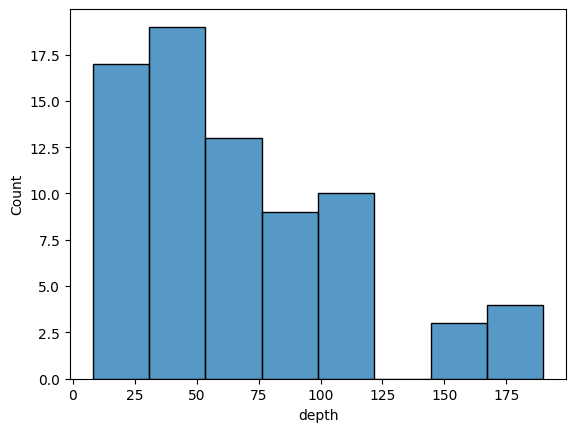

In [10]:
sns.histplot(df['depth'])

In [72]:
len(ENCODERs)//2

5

In [103]:
df.iloc[df['MAE Train'].idxmin()]

AL                         5
RUD                        1
pairs        M-M-CZ_Full-CRZ
MAE Train          18.902224
MAE Test           19.505385
num_gates                180
depth                    106
Name: 43, dtype: object

In [106]:
df['num_gates'].max()

420

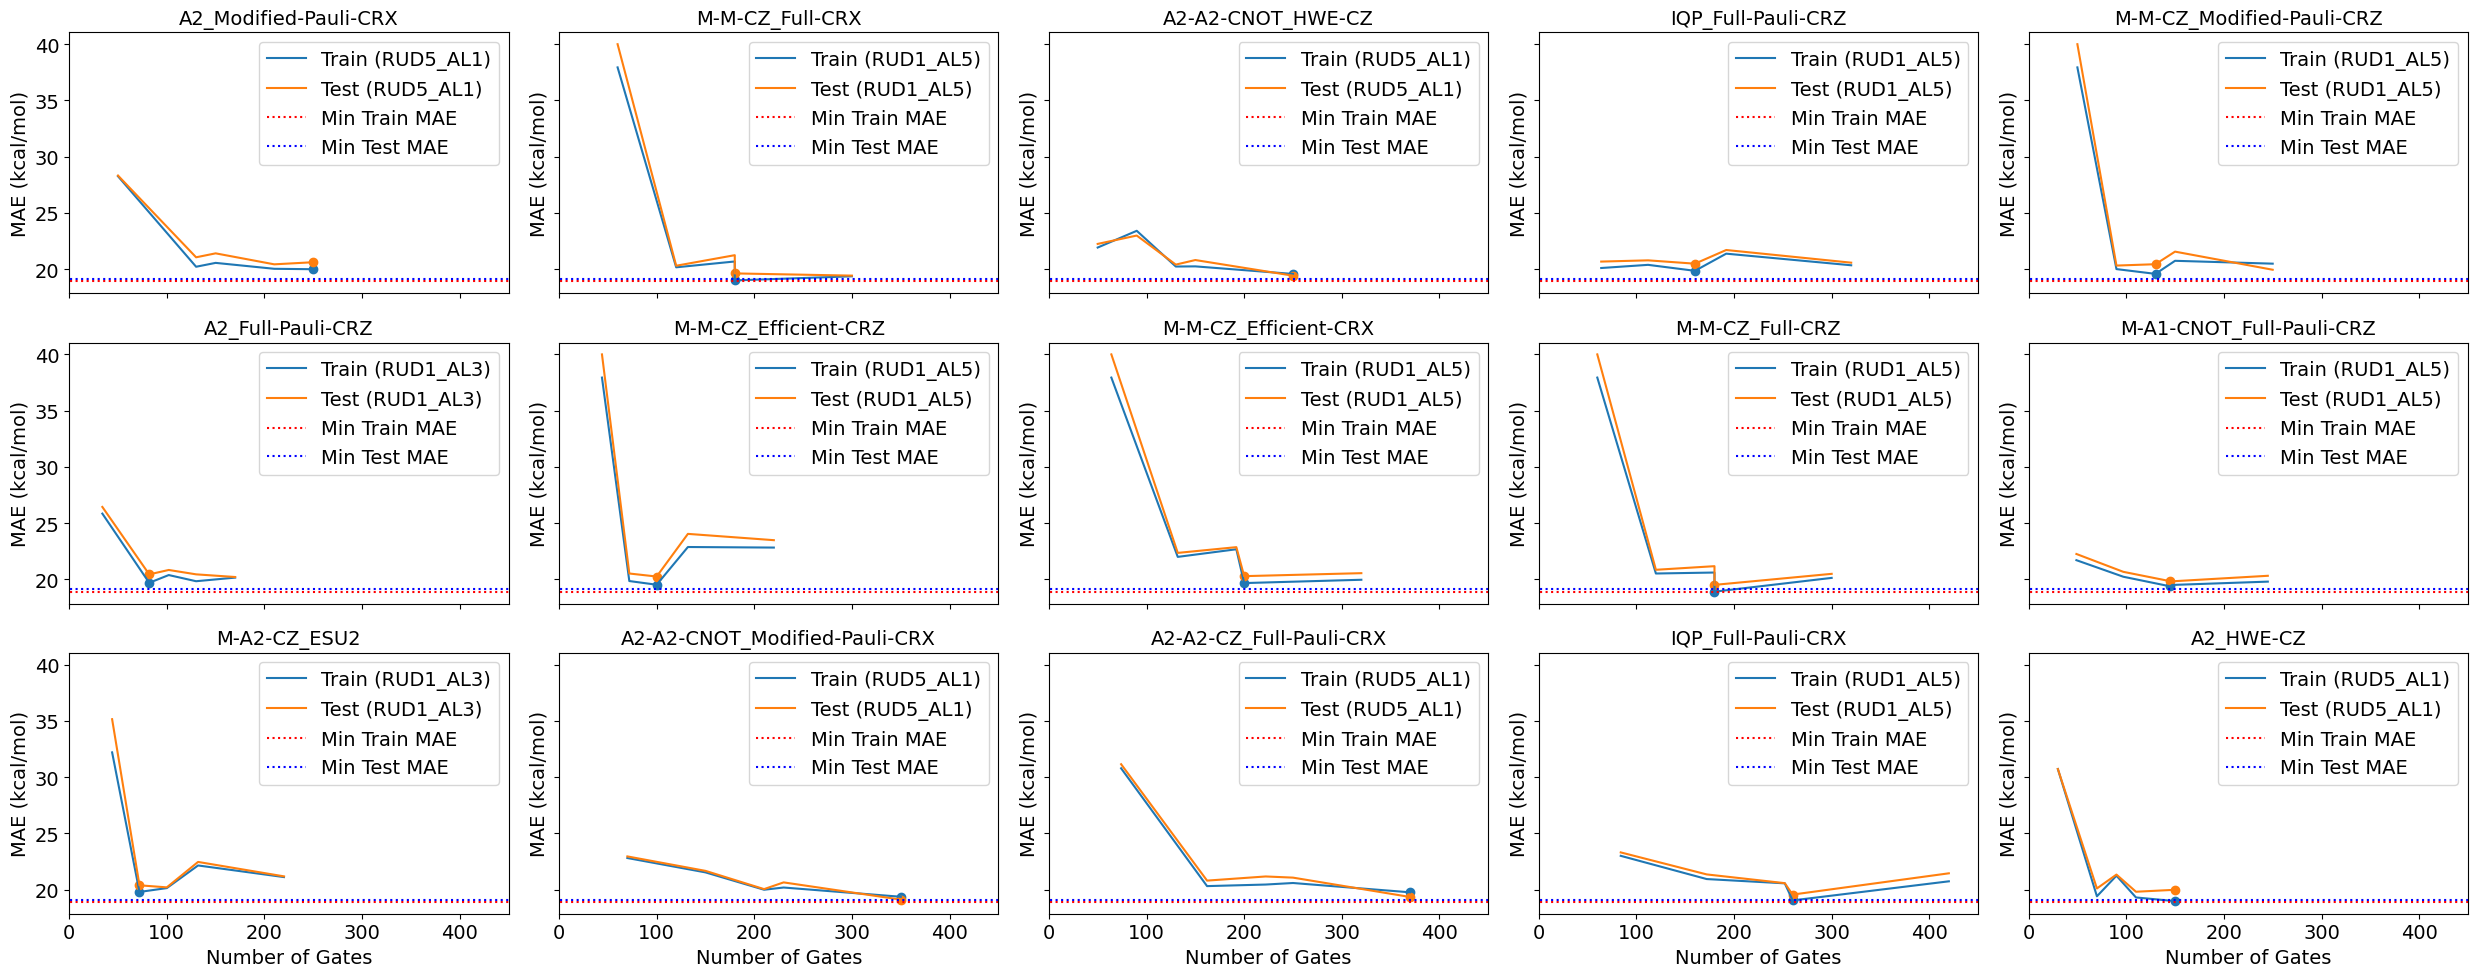

In [117]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

fig,ax=plt.subplots(3,len(pairs)//3,sharey=True,sharex=True,figsize=(25,10))


for idxe,p in enumerate(pairs):
    
        pairdf=df[df['pairs']==p].sort_values(by=["num_gates"])
        min=pairdf.sort_values(by=['MAE Train',"MAE Test"]).iloc[0]
        ax[idxe%3,idxe%5].plot(pairdf['num_gates'],pairdf['MAE Train'],label=f'Train'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
        ax[idxe%3,idxe%5].plot(pairdf['num_gates'],pairdf['MAE Test'],label=f'Test'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
        ax[idxe%3,idxe%5].scatter(min['num_gates'],min['MAE Train'])
        ax[idxe%3,idxe%5].scatter(min['num_gates'],min['MAE Test'])
        ax[idxe%3,idxe%5].hlines(df['MAE Train'].min(),-10,500,color='r',linestyles=':',label="Min Train MAE")
        ax[idxe%3,idxe%5].hlines(df['MAE Test'].min(),-10,500,color='b',linestyles=':',label="Min Test MAE")
        ax[idxe%3,idxe%5].legend(loc=1)
        ax[idxe%3,idxe%5].set_ylabel('MAE (kcal/mol)')
        ax[idxe%3,idxe%5].set_xlim(0,450)
        ax[idxe%3,idxe%5].set_title(p)

        if (idxe%3)==2:
            ax[idxe%3,idxe%5].set_xlabel('Number of Gates')

        
plt.tight_layout()        
plt.show()

In [123]:
pairdf

,AL,RUD,pairs,MAE Train,MAE Test,num_gates,depth
74,1,1,A2_HWE-CZ,30.714735,30.713218,30,10
14,3,1,A2_HWE-CZ,19.395952,20.094300,70,26
29,1,3,A2_HWE-CZ,21.226429,21.328395,90,30
44,5,1,A2_HWE-CZ,19.293560,19.801925,110,42
59,1,5,A2_HWE-CZ,18.967704,19.975385,150,50


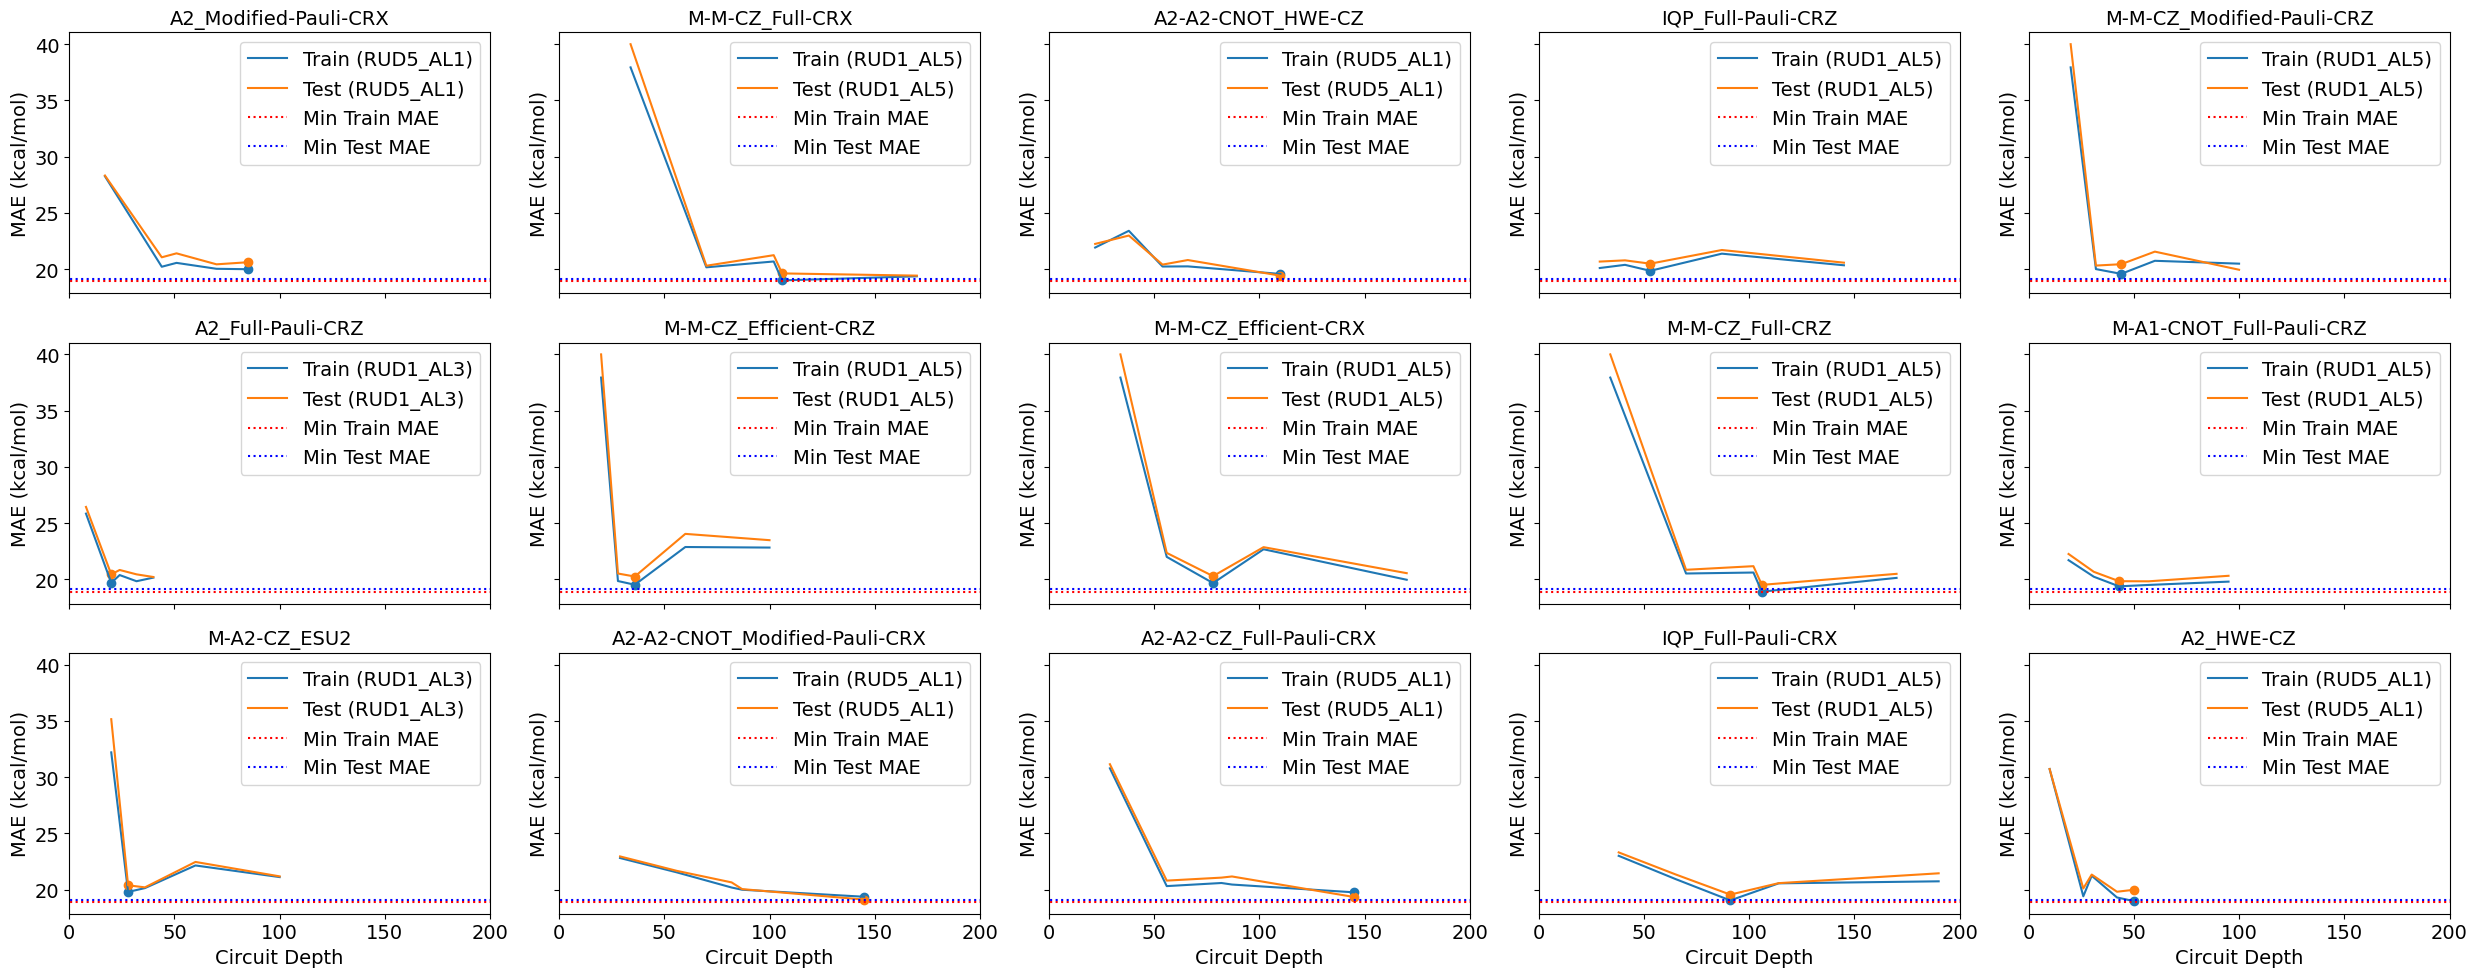

In [122]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

fig,ax=plt.subplots(3,len(pairs)//3,sharey=True,sharex=True,figsize=(25,10))


for idxe,p in enumerate(pairs):
    
        pairdf=df[df['pairs']==p].sort_values(by=["depth"])
        min=pairdf.sort_values(by=['MAE Train',"MAE Test"]).iloc[0]
        ax[idxe%3,idxe%5].plot(pairdf['depth'],pairdf['MAE Train'],label=f'Train'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
        ax[idxe%3,idxe%5].plot(pairdf['depth'],pairdf['MAE Test'],label=f'Test'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
        ax[idxe%3,idxe%5].scatter(min['depth'],min['MAE Train'])
        ax[idxe%3,idxe%5].scatter(min['depth'],min['MAE Test'])
        ax[idxe%3,idxe%5].hlines(df['MAE Train'].min(),-10,500,color='r',linestyles=':',label="Min Train MAE")
        ax[idxe%3,idxe%5].hlines(df['MAE Test'].min(),-10,500,color='b',linestyles=':',label="Min Test MAE")
        ax[idxe%3,idxe%5].legend(loc=1)
        ax[idxe%3,idxe%5].set_ylabel('MAE (kcal/mol)')
        ax[idxe%3,idxe%5].set_xlim(0,200)
        ax[idxe%3,idxe%5].set_title(p)

        if (idxe%3)==2:
            ax[idxe%3,idxe%5].set_xlabel('Circuit Depth')

        
plt.tight_layout()        
plt.show()

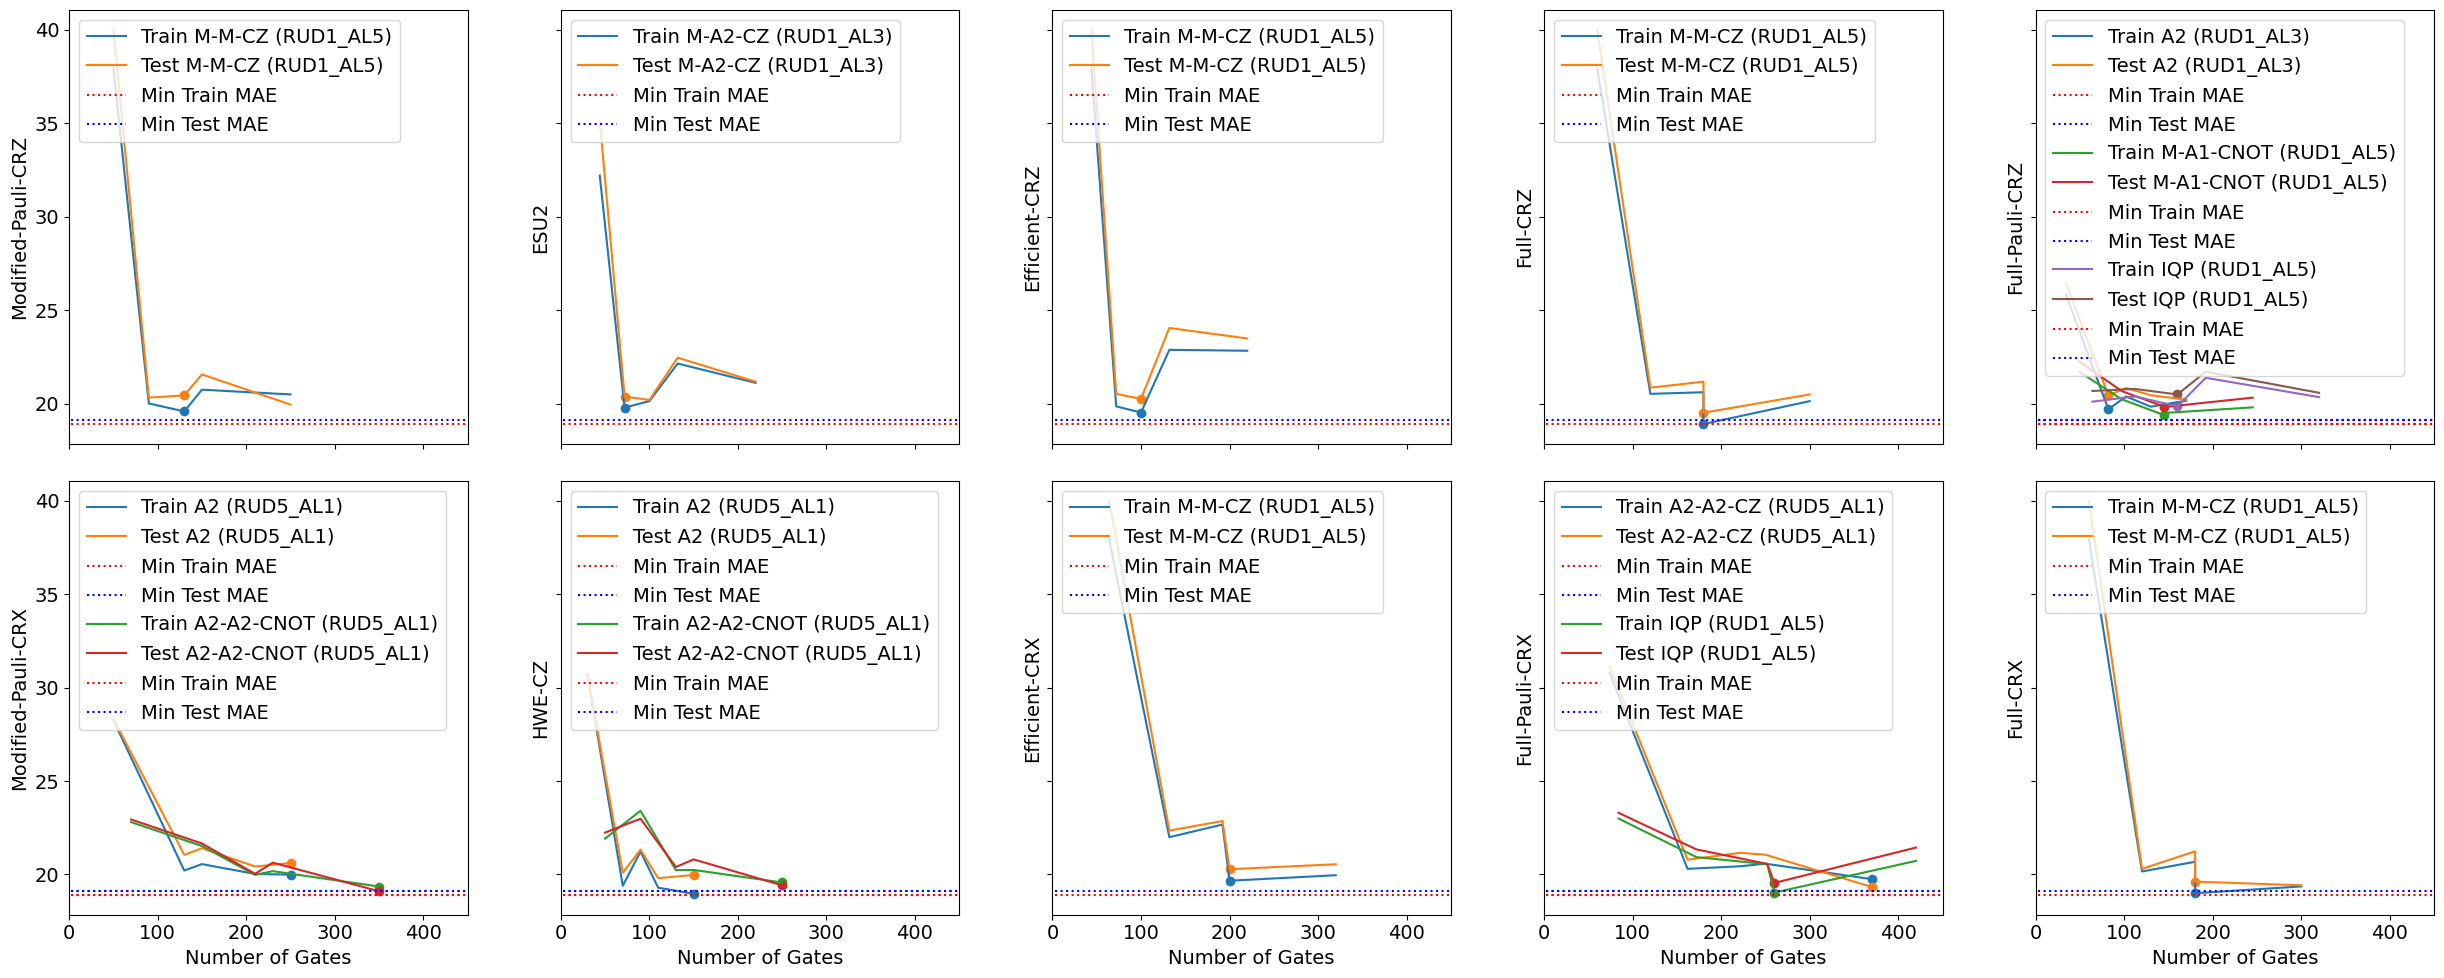

In [110]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

fig,ax=plt.subplots(2,len(ENCODERs)//2,sharey=True,sharex=True,figsize=(25,10))

for idxa,a in enumerate(ANSATZs):
    for idxe,e in enumerate(ENCODERs):
        if '_'.join((a,e)) in pairs:
            pairdf=df[df['pairs']=='_'.join((a,e))].sort_values(by=["num_gates"])
            min=pairdf.sort_values(by=['MAE Train',"MAE Test"]).iloc[0]
            ax[idxe%2,idxe%5].plot(pairdf['num_gates'],pairdf['MAE Train'],label=f'Train {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
            ax[idxe%2,idxe%5].plot(pairdf['num_gates'],pairdf['MAE Test'],label=f'Test {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
            ax[idxe%2,idxe%5].scatter(min['num_gates'],min['MAE Train'])
            ax[idxe%2,idxe%5].scatter(min['num_gates'],min['MAE Test'])
            ax[idxe%2,idxe%5].hlines(df['MAE Train'].min(),-10,500,color='r',linestyles=':',label="Min Train MAE")
            ax[idxe%2,idxe%5].hlines(df['MAE Test'].min(),-10,500,color='b',linestyles=':',label="Min Test MAE")
            ax[idxe%2,idxe%5].legend(loc=2)
            ax[idxe%2,idxe%5].set_ylabel(e)
            ax[idxe%2,idxe%5].set_xlim(0,450)

            if (idxe%2)==1:
                ax[idxe%2,idxe%5].set_xlabel('Number of Gates')
    
        
plt.tight_layout()        
plt.show()

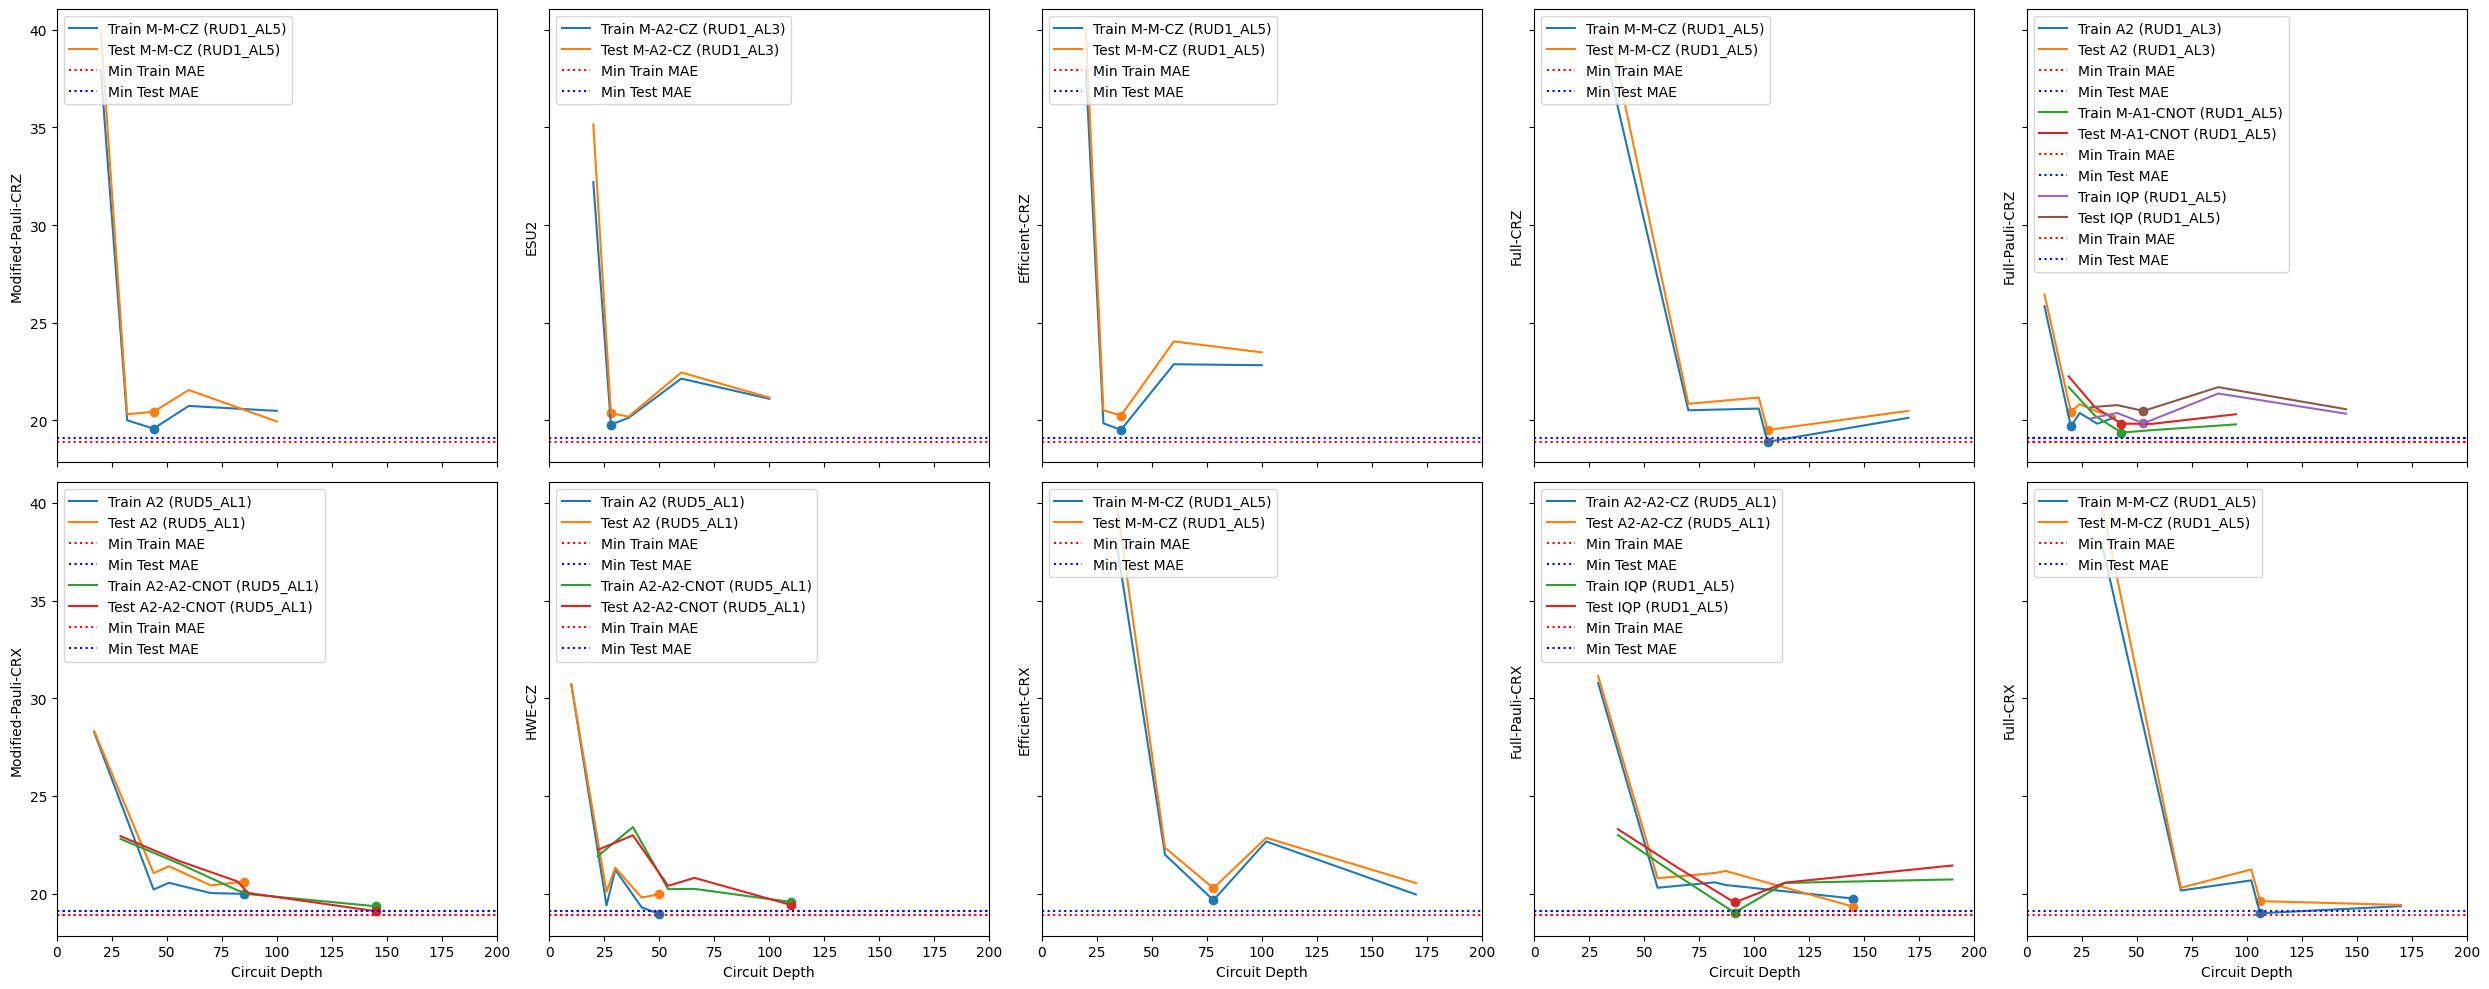

In [104]:
fig,ax=plt.subplots(2,len(ENCODERs)//2,sharey=True,sharex=True,figsize=(25,10))

for idxa,a in enumerate(ANSATZs):
    for idxe,e in enumerate(ENCODERs):
        if '_'.join((a,e)) in pairs:
            pairdf=df[df['pairs']=='_'.join((a,e))].sort_values(by=["depth"])
            min=pairdf.sort_values(by=['MAE Train',"MAE Test"]).iloc[0]
            ax[idxe%2,idxe%5].plot(pairdf['depth'],pairdf['MAE Train'],label=f'Train {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
            ax[idxe%2,idxe%5].plot(pairdf['depth'],pairdf['MAE Test'],label=f'Test {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
            ax[idxe%2,idxe%5].scatter(min['depth'],min['MAE Train'])
            ax[idxe%2,idxe%5].scatter(min['depth'],min['MAE Test'])
            ax[idxe%2,idxe%5].hlines(df['MAE Train'].min(),-10,300,color='r',linestyles=':',label="Min Train MAE")
            ax[idxe%2,idxe%5].hlines(df['MAE Test'].min(),-10,300,color='b',linestyles=':',label="Min Test MAE")
            ax[idxe%2,idxe%5].legend(loc=2)
            ax[idxe%2,idxe%5].set_ylabel(e)
            ax[idxe%2,idxe%5].set_xlim(0,200)

            if (idxe%2)==1:
                ax[idxe%2,idxe%5].set_xlabel('Circuit Depth')
    
        
plt.tight_layout()        
plt.show()

In [41]:
# for p in pairs:
#     sns.lineplot(df[df['pairs']==p].melt(id_vars=['num_gates','depth'],value_vars=['MAE Train','MAE Test']),x='depth',y='value',hue='variable')
#     plt.show()

In [15]:
layerdf=df.melt(id_vars=['AL','RUD'],value_vars=['MAE Train','MAE Test'])

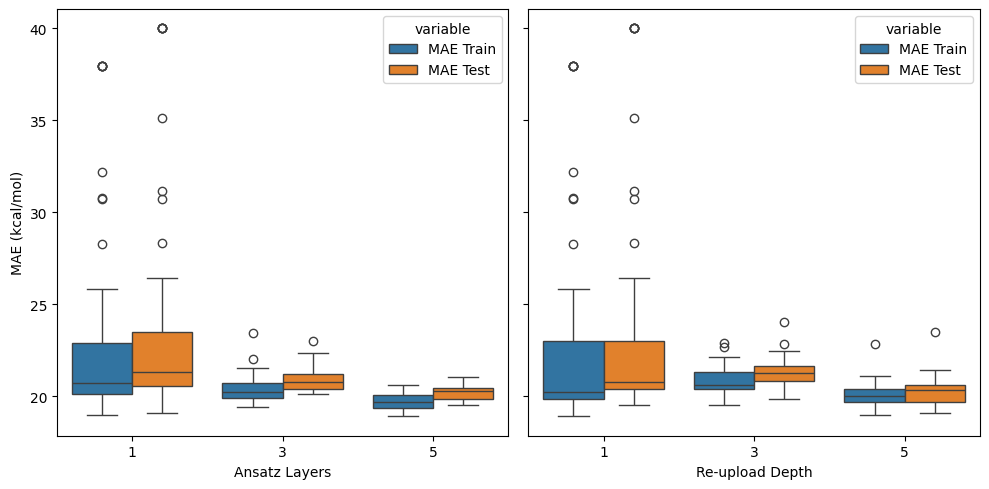

In [70]:
fig,ax=plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.boxplot(data=layerdf,y='value',hue='variable',x='AL',ax=ax[0])
sns.boxplot(data=layerdf,y='value',hue='variable',x='RUD',ax=ax[1])
ax[0].set_ylabel('MAE (kcal/mol)')
ax[0].set_xlabel('Ansatz Layers')
ax[1].set_xlabel('Re-upload Depth')
plt.tight_layout()
plt.savefig('MAE_vs_layers.png',dpi=300)
plt.show()

<Axes: xlabel='RUD', ylabel='value'>

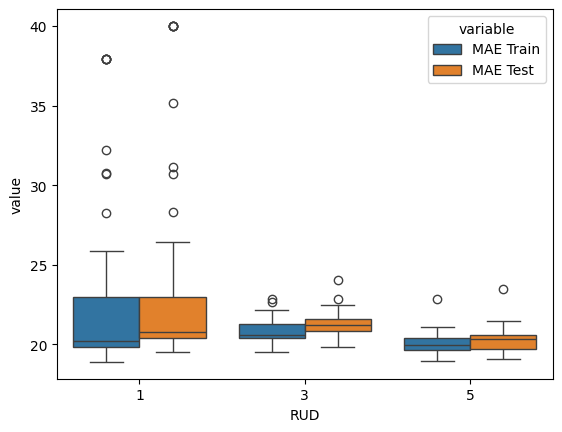

In [18]:
depthdf=df.melt(id_vars=['num_gates','depth'],value_vars=['MAE Train','MAE Test'])

In [19]:
# sns.histplot(df[df['num_gates']<=200],hue='variable',x='value',palette=sns.color_palette('Paired',2))
# sns.histplot(df,hue='variable',x='value',palette=sns.color_palette('rocket',2))
# plt.show()

<Axes: xlabel='value', ylabel='num_gates'>

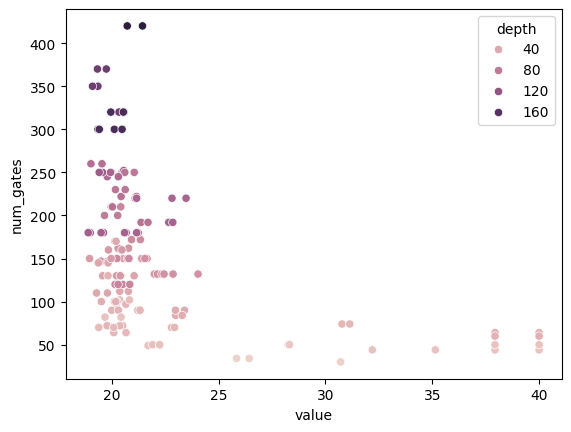

In [20]:
sns.scatterplot(data=depthdf,x='value',hue='depth',y='num_gates')

<Axes: xlabel='num_gates', ylabel='value'>

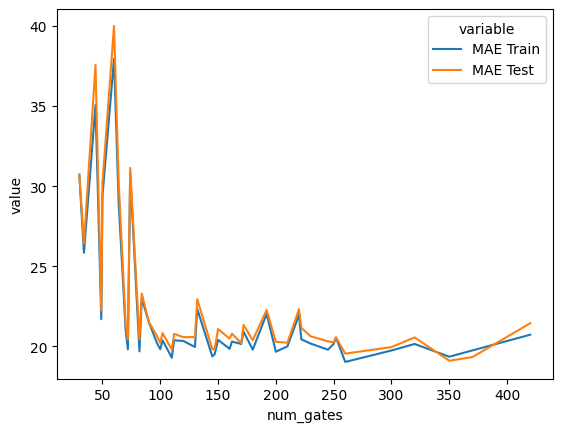

In [24]:
sns.lineplot(data=depthdf,y='value',hue='variable',x='num_gates',errorbar=None)

<Axes: xlabel='depth', ylabel='value'>

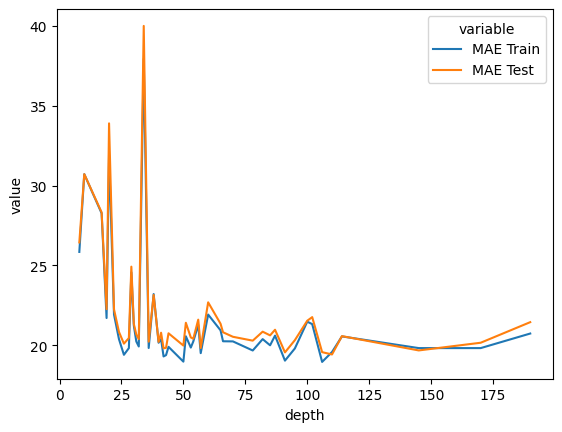

In [57]:

sns.lineplot(data=depthdf,y='value',hue='variable',x='depth',errorbar=None)